# DeepHit for Single Event

In this notebook we show an example of how we can fit a [DeepHit](http://medianetlab.ee.ucla.edu/papers/AAAI_2018_DeepHit) model when we only have *one* event type.

If you are interested in **competing risks**, see [this notebook](https://nbviewer.jupyter.org/github/havakv/pycox/blob/master/examples/deephit_competing_risks.ipynb) instead.

For a more verbose introduction to `pycox` see [this notebook](https://nbviewer.jupyter.org/github/havakv/pycox/blob/master/examples/01_introduction.ipynb).

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 

import torch # For building the networks 
import torchtuples as tt # Some useful functions

from pycox.datasets import kkbox_v1
from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv
from pycox.preprocessing.feature_transforms import OrderedCategoricalLong


In [9]:
## Uncomment to install `sklearn-pandas`
# ! pip install sklearn-pandas

In [10]:
np.random.seed(1234)
_ = torch.manual_seed(123)

## Dataset

We load the KKBox data set as a pandas DataFrame and split the data in in train, test and validation.

The `duration` column gives the observed times and the `event` column contains indicators of whether the observation is an event (1) or a censored observation (0).

In [48]:
df_train = kkbox_v1.read_df()
df_train['gender'] = df_train['gender'].cat.add_categories('Unknown')
df_train['gender'].replace(['female','male','Unknown'], [1,2,0],inplace=True)
df_train['gender'].fillna(0)
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)


In [49]:
df_train

,msno,event,n_prev_churns,log_days_between_subs,duration,log_days_since_reg_init,log_payment_plan_days,log_plan_list_price,log_actual_amount_paid,is_auto_renew,is_cancel,city,gender,registered_via,age_at_start,strange_age,nan_days_since_reg_init,no_prev_churns
0,QIFF2cH33T5Wsxo9rDsibbR9xoIlTdsX0fCf2aHVbig=,1.0,0.0,0.000000,41.0,6.492240,3.433987,5.010635,5.010635,1.0,0.0,11,1,9,22.0,0.0,0.0,1.0
2,+t8dRJBgmtjq3Puhbr5NRkojTM5hosvSZBBd+9U8L9E=,1.0,0.0,0.000000,31.0,4.795791,3.433987,5.010635,5.010635,1.0,0.0,1,NaN,7,0.0,1.0,0.0,1.0
3,9VanP7ua+0umrX2RZQXIE5bxHmrydH7P47yldfzdrZM=,1.0,0.0,0.000000,7.0,5.579730,2.079442,0.000000,0.000000,0.0,0.0,18,2,9,25.0,0.0,0.0,1.0
4,9VanP7ua+0umrX2RZQXIE5bxHmrydH7P47yldfzdrZM=,1.0,1.0,4.007333,7.0,5.786897,2.079442,0.000000,0.000000,0.0,0.0,18,2,9,25.0,0.0,0.0,0.0
6,ZpDnY7PvvNLOcDipa2MrePKmjdb2HvNc53pS4sx6g7k=,1.0,1.0,0.000000,37.0,7.994295,3.433987,5.010635,5.010635,1.0,1.0,21,2,9,30.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1570462,gXpmHqEImx6bgvaxBoR11ZaemtFyjEmBoM2XGSIAVkc=,0.0,0.0,0.000000,30.0,6.520621,3.433987,5.010635,5.010635,0.0,0.0,21,2,9,20.0,0.0,0.0,1.0
1570464,l5qEX/nroq+6xJUWEPPiSlV0pPuP9etyesd86Co2to0=,0.0,0.0,0.000000,27.0,7.402452,3.433987,5.010635,5.010635,1.0,0.0,15,1,3,28.0,0.0,0.0,1.0
1570465,43lBMe/8LXZH82AbcBMWuUzyt6BAC7fFPC7ZJ38su18=,0.0,0.0,0.000000,28.0,6.366470,3.433987,4.605170,4.605170,1.0,0.0,1,NaN,7,-0.0,1.0,0.0,1.0
1570466,tM305rNacBoojqZkYsKDh+qg4QH8wHTgZ1L3lwn0Ph0=,1.0,0.0,0.000000,1.0,0.000000,3.433987,5.010635,5.010635,1.0,1.0,NaN,NaN,NaN,-1.0,0.0,1.0,1.0


## Feature transforms

The METABRIC dataset has  9 covariates: `x0, ..., x8`.
We will standardize the 5 numerical covariates, and leave the binary covariates as is.
Note that PyTorch require variables of type `'float32'`.

We like using the `sklearn_pandas.DataFrameMapper` to make feature mappers.

In [50]:
cols_standardize = ['log_days_between_subs', 'n_prev_churns','log_days_since_reg_init', 
                    'log_payment_plan_days', 'log_plan_list_price', 
                    'log_actual_amount_paid', 'age_at_start']
cols_leave = ['no_prev_churns', 'is_cancel', 'strange_age', 'is_auto_renew', 
              'nan_days_since_reg_init']
cols_categorical =  ['gender', 'city', 'registered_via']


standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]
categorical = [(col, OrderedCategoricalLong()) for col in cols_categorical]

x_mapper_float = DataFrameMapper(standardize + leave)
x_mapper_long = DataFrameMapper(categorical)  # we need a separate mapper to ensure the data type 'int64'

In [51]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

## Label transforms

The survival methods require individual label transforms, so we have included a proposed `label_transform` for each method.
In this case `label_transform` is just a shorthand for the class `pycox.preprocessing.label_transforms.LabTransDiscreteTime`.

DeepHit is a discrete-time method, meaning it requires discretization of the event times to be applied to continuous-time data.
We let `num_durations` define the size of this (equidistant) discretization grid, meaning our network will have `num_durations` output nodes.

In [52]:
num_durations = 10
labtrans = DeepHitSingle.label_transform(num_durations)
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

In [53]:
type(labtrans)

pycox.preprocessing.label_transforms.LabTransDiscreteTime

## Neural net

We make a neural net with `torch`.
For simple network structures, we can use the `MLPVanilla` provided by `torchtuples`.
For building more advanced network architectures, see for example [the tutorials by PyTroch](https://pytorch.org/tutorials/).

The following net is an MLP with two hidden layers (with 32 nodes each), ReLU activations, and `num_nodes` output nodes.
We also have batch normalization and dropout between the layers.

In [54]:
in_features = x_train.shape[1]
num_nodes = [512, 512, 512, 512, 512, 512]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

If you instead want to build this network with `torch` you can uncomment the following code.
It is essentially equivalent to the `MLPVanilla`, but without the `torch.nn.init.kaiming_normal_` weight initialization.

In [55]:
# net = torch.nn.Sequential(
#     torch.nn.Linear(in_features, 32),
#     torch.nn.ReLU(),
#     torch.nn.BatchNorm1d(32),
#     torch.nn.Dropout(0.1),
    
#     torch.nn.Linear(32, 32),
#     torch.nn.ReLU(),
#     torch.nn.BatchNorm1d(32),
#     torch.nn.Dropout(0.1),
    
#     torch.nn.Linear(32, out_features)
# )

## Training the model

To train the model we need to define an optimizer. You can choose any `torch.optim` optimizer, but here we instead use one from `tt.optim` as it has some added functionality.
We use the `Adam` optimizer, but instead of choosing a learning rate, we will use the scheme proposed by [Smith 2017](https://arxiv.org/pdf/1506.01186.pdf) to find a suitable learning rate with `model.lr_finder`. See [this post](https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6) for an explanation.

We also set `duration_index` which connects the output nodes of the network the the discretization times. This is only useful for prediction and does not affect the training procedure.

DeepHit has a loss that is a combination of a negative log-likelihood and a ranking loss. `alpha` is a parameter that controls the linear combination between the two, and `sigma` is a parameter used by the ranking loss. `alpha = 1` give a loss only containing the negative log-likelihood and `alpha = 0` give a pure ranking loss. Note that this is different than the original paper.

In [56]:
model = DeepHitSingle(net, tt.optim.Adam, alpha=0.001 , sigma=0.5, duration_index=labtrans.cuts)


/home/thomas/Downloads/Enter/lib/python3.9/site-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **k

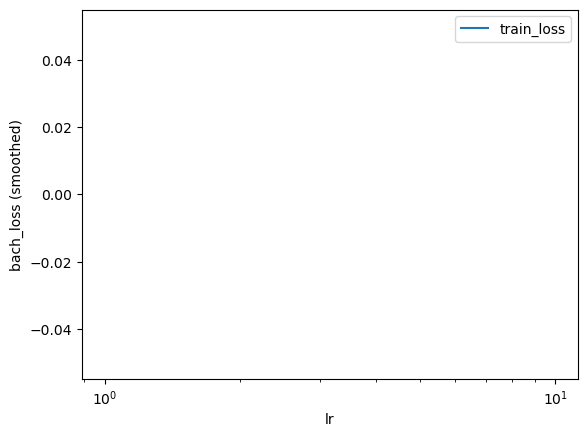

In [57]:
batch_size = 256
lr_finder = model.lr_finder(x_train, y_train, batch_size, tolerance=3)
_ = lr_finder.plot()

In [58]:
lr_finder.get_best_lr()

0.0001

Often, this learning rate is a little high, so we instead set it manually to 0.01

In [59]:
model.optimizer.set_lr(0.001)

We include the `EarlyStopping` callback to stop training when the validation loss stops improving. After training, this callback will also load the best performing model in terms of validation loss.

In [60]:
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	:11s / 2m:11s],	
1:	:13s / 4m:24s],	
2:	:2s / 6m:27s],	
3:	:1s / 8m:28s],	
4:	:8s / 10m:37s],	
5:	:17s / 12m:54s],	
6:	:59s / 14m:53s],	
7:	:20s / 17m:14s],	
8:	:2s / 19m:16s],	
9:	:15s / 21m:32s],	


/home/thomas/Downloads/Enter/lib/python3.9/site-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **k

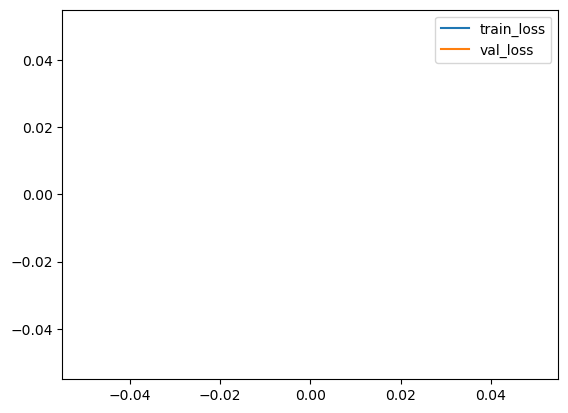

In [61]:
_ = log.plot()

## Prediction

For evaluation we first need to obtain survival estimates for the test set.
This can be done with `model.predict_surv` which returns an array of survival estimates, or with `model.predict_surv_df` which returns the survival estimates as a dataframe.

In [62]:
surv = model.predict_surv_df(x_test)

We can plot the survival estimates for the first 5 individuals.
Note that the time scale is correct because we have set `model.duration_index` to be the grid points.
We have, however, only defined the survival estimates at the 10 times in our discretization grid, so, the survival estimates is a step function

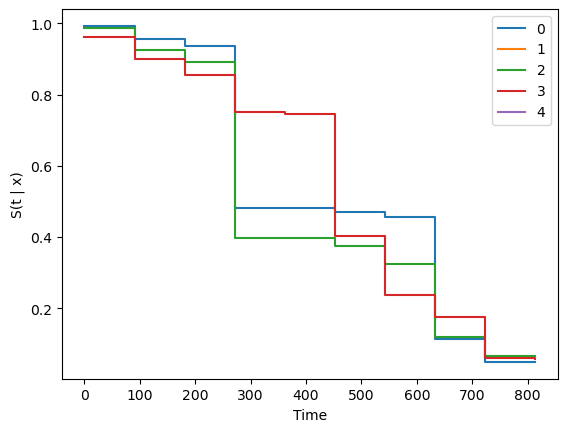

In [63]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

It is, therefore, often beneficial to interpolate the survival estimates, see [this paper](https://arxiv.org/abs/1910.06724) for a discussion.
Linear interpolation (constant density interpolation) can be performed with the `interpolate` method. We also need to choose how many points we want to replace each grid point with. Her we will use 10.

In [64]:
surv = model.interpolate(10).predict_surv_df(x_test)

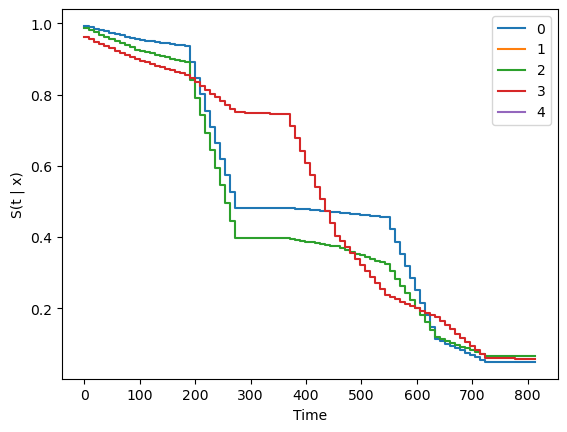

In [65]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [66]:
haz = model.predict_haz_df(x_test)

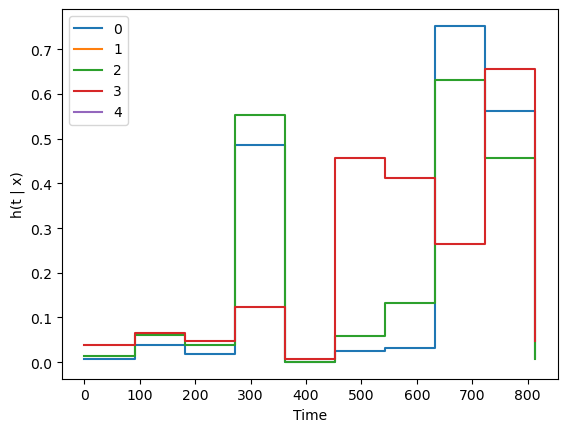

In [67]:
haz.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('h(t | x)')
_ = plt.xlabel('Time')

In [68]:
haz = model.interpolate(10).predict_hazard_df(x_test)

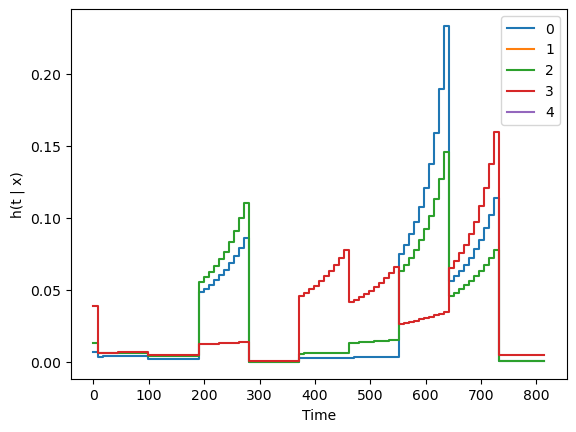

In [69]:
haz.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('h(t | x)')
_ = plt.xlabel('Time')

## Evaluation

The `EvalSurv` class contains some useful evaluation criteria for time-to-event prediction.
We set `censor_surv = 'km'` to state that we want to use Kaplan-Meier for estimating the censoring distribution.


In [70]:
ev = EvalSurv(surv, haz, durations_test, events_test, censor_surv='km')

#### Concordance

We start with the event-time concordance by [Antolini et al. 2005](https://onlinelibrary.wiley.com/doi/10.1002/sim.2427).

In [71]:
ev.concordance_td('antolini')

0.17109606545521275

In [72]:
ev.concordance_alpha()

0.23015792062684526

#### Brier Score

We can plot the the [IPCW Brier score](https://onlinelibrary.wiley.com/doi/abs/10.1002/%28SICI%291097-0258%2819990915/30%2918%3A17/18%3C2529%3A%3AAID-SIM274%3E3.0.CO%3B2-5) for a given set of times.
Here we just use 100 time-points between the min and max duration in the test set.
Note that the score becomes unstable for the highest times. It is therefore common to disregard the rightmost part of the graph.

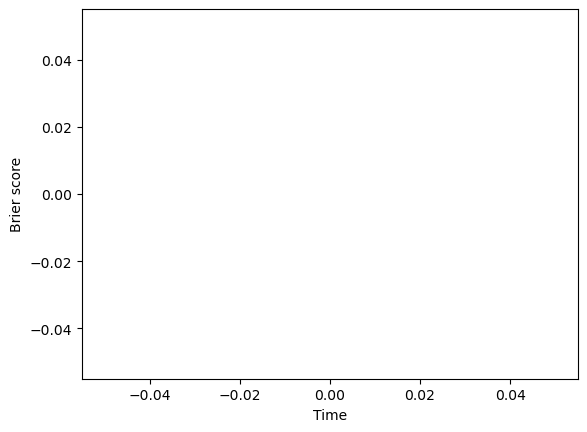

In [73]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

#### Negative binomial log-likelihood

In a similar manner, we can plot the the [IPCW negative binomial log-likelihood](https://onlinelibrary.wiley.com/doi/abs/10.1002/%28SICI%291097-0258%2819990915/30%2918%3A17/18%3C2529%3A%3AAID-SIM274%3E3.0.CO%3B2-5).

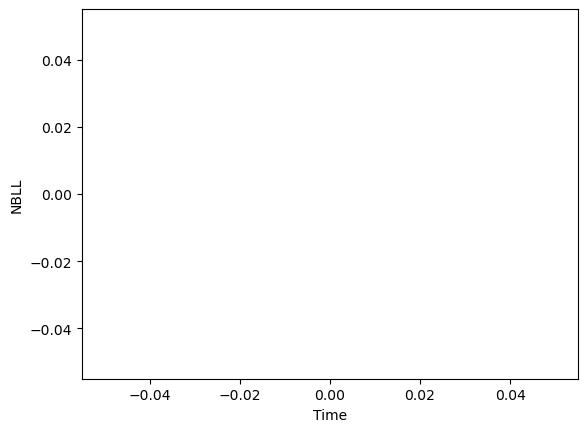

In [74]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

#### Integrated scores

The two time-dependent scores above can be integrated over time to produce a single score [Graf et al. 1999](https://onlinelibrary.wiley.com/doi/abs/10.1002/%28SICI%291097-0258%2819990915/30%2918%3A17/18%3C2529%3A%3AAID-SIM274%3E3.0.CO%3B2-5). In practice this is done by numerical integration over a defined `time_grid`.

In [75]:
ev.integrated_brier_score(time_grid) 

nan

In [76]:
ev.integrated_nbll(time_grid) 

nan